In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
111403,00030456_000.png,No Finding,0,30456,46,F,PA,2021,2021,0.194311,0.194311,NaN
48322,00012249_000.png,No Finding,0,12249,27,F,PA,2974,2991,0.143000,0.143000,NaN
10324,00002673_020.png,Consolidation,20,2673,26,M,AP,2500,2048,0.168000,0.168000,NaN


In [3]:
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1965,00010294_009.png,Atelectasis|Effusion,9,10294,050Y,M,AP,2500,2048,0.168,0.168
3661,00018006_028.png,Effusion|Mass|Nodule,28,18006,061Y,M,AP,2500,2048,0.168,0.168
3489,00017158_017.png,No Finding,17,17158,059Y,M,AP,2500,2048,0.168,0.168


In [4]:
## EDA
# Split Finding Labels column and turn each label into a column with a binary Flag
labels = np.unique(list(chain(*all_xray_df["Finding Labels"].map(lambda x: x.split("|")))))
print("Labels: ", labels)
for label in labels:
    all_xray_df[label] = all_xray_df["Finding Labels"].map(lambda x: 1 if label in x else 0)
    
all_xray_df.sample(3)

Labels:  ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
7481,00001967_000.png,Fibrosis,0,1967,33,M,PA,2500,2048,0.168,...,0,1,0,0,0,0,0,0,0,0
83803,00020594_001.png,Fibrosis|Infiltration,1,20594,58,M,PA,3056,2512,0.139,...,0,1,0,1,0,0,0,0,0,0
93729,00023604_005.png,No Finding,5,23604,54,M,PA,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0


### Population Caracteristics

#### Age

In [5]:
df_length = len(all_xray_df)
df_older100 = len(all_xray_df["Patient Age"][all_xray_df["Patient Age"] > 100])
print("Age Count\n", all_xray_df["Patient Age"][all_xray_df["Patient Age"] > 100].value_counts())
print("\nData frame length: ", df_length)
print("Number of patients older than 100 years old: ", df_older100)
print("Patients older than 100 years old: %0.2f %%"%(df_older100 / df_length * 100))

Age Count
 412    3
148    2
155    2
414    1
413    1
411    1
154    1
153    1
152    1
151    1
150    1
149    1
Name: Patient Age, dtype: int64

Data frame length:  112120
Number of patients older than 100 years old:  16
Patients older than 100 years old: 0.01 %


There are patients with ages older than 100 years old in the data set. Each year bigger than 100 appears only once in the data set most of the time, so they are likely input errors and will be ignored for the age distribution.

Minimum age:  1
Maximum age:  95


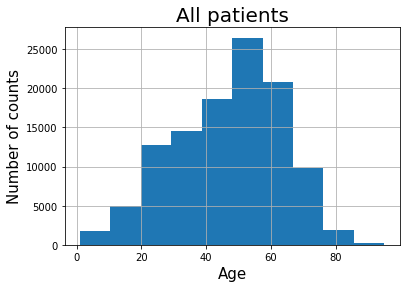

In [6]:
filt1 = (all_xray_df["Patient Age"] < 100)

age_pop = all_xray_df["Patient Age"][filt1]
_ = age_pop.hist()
_ = plt.xlabel("Age", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("All patients", size=20)

print("Minimum age: ", min(age_pop))
print("Maximum age: ", max(age_pop))

Minimum age:  2
Maximum age:  90


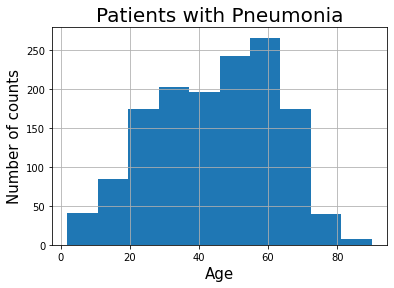

In [7]:
filt2 = (all_xray_df.Pneumonia == 1)

age_pop = all_xray_df["Patient Age"][filt1 & filt2]
_ = age_pop.hist()
_ = plt.xlabel("Age", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("Patients with Pneumonia", size=20)

print("Minimum age: ", min(age_pop))
print("Maximum age: ", max(age_pop))

The data set population includes individuals from 1 to 95 years old with a peak around 50. The population with penumonia includes individuals from 2 to 90 years old with a peak around 60.

#### Sex

Males: 56.49 %
Females: 43.51 %


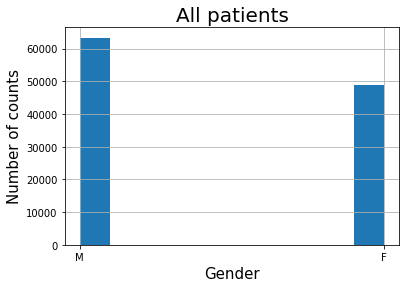

In [8]:
sex_pop = all_xray_df["Patient Gender"]
_ = sex_pop.hist()
_ = plt.xlabel("Gender", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("All patients", size=20)

numM = sex_pop.value_counts()[0]
numF = sex_pop.value_counts()[1]
print("Males: %.2f %%"%(100 * numM / len(sex_pop)))
print("Females: %.2f %%"%(100 * numF / len(sex_pop)))

Males: 58.56 %
Females: 41.44 %


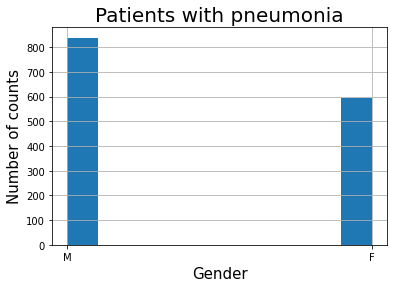

In [12]:
sex_pop = all_xray_df["Patient Gender"][filt2]
_ = sex_pop.hist()
_ = plt.xlabel("Gender", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("Patients with pneumonia", size=20)

numM = sex_pop.value_counts()[0]
numF = sex_pop.value_counts()[1]
print("Males: %.2f %%"%(100 * numM / len(sex_pop)))
print("Females: %.2f %%"%(100 * numF / len(sex_pop)))

Considering population gender, males are dominant for the total population and the population with pneumonia.

#### X-ray view position

PA: 60.03 %
AP: 39.97 %


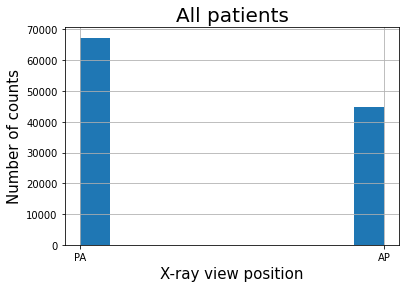

In [10]:
position_pop = all_xray_df["View Position"]
_ = position_pop.hist()
_ = plt.xlabel("X-ray view position", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("All patients", size=20)

numPA = position_pop.value_counts()[0]
numAP = position_pop.value_counts()[1]
print("PA: %.2f %%"%(100 * numPA / len(position_pop)))
print("AP: %.2f %%"%(100 * numAP / len(position_pop)))

PA: 55.97 %
AP: 44.03 %


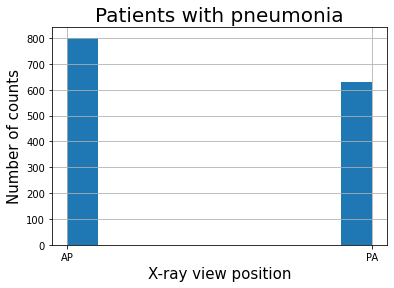

In [13]:
position_pop = all_xray_df["View Position"][filt2]
_ = position_pop.hist()
_ = plt.xlabel("X-ray view position", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("Patients with pneumonia", size=20)

numPA = position_pop.value_counts()[0]
numAP = position_pop.value_counts()[1]
print("PA: %.2f %%"%(100 * numPA / len(position_pop)))
print("AP: %.2f %%"%(100 * numAP / len(position_pop)))

The PA position is predominant for all patients as well as for patients with pneumonia.

#### Presence of pneumonia

Absence of pneumonia: 98.72 %
Presence of pneumonia: 1.28 %


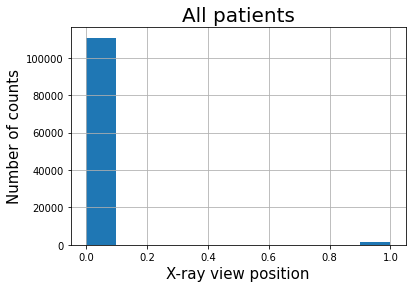

In [129]:
pneumonia_pop = all_xray_df.Pneumonia
_ = pneumonia_pop.hist()
_ = plt.xlabel("X-ray view position", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("All patients", size=20)

num0 = pneumonia_pop.value_counts()[0]
num1 = pneumonia_pop.value_counts()[1]
print("Absence of pneumonia: %.2f %%"%(100 * num0 / len(pneumonia_pop)))
print("Presence of pneumonia: %.2f %%"%(100 * num1 / len(pneumonia_pop)))

Only 1.28% of the analyzed population has pneumonia.

### Comorbidities with pneumonia

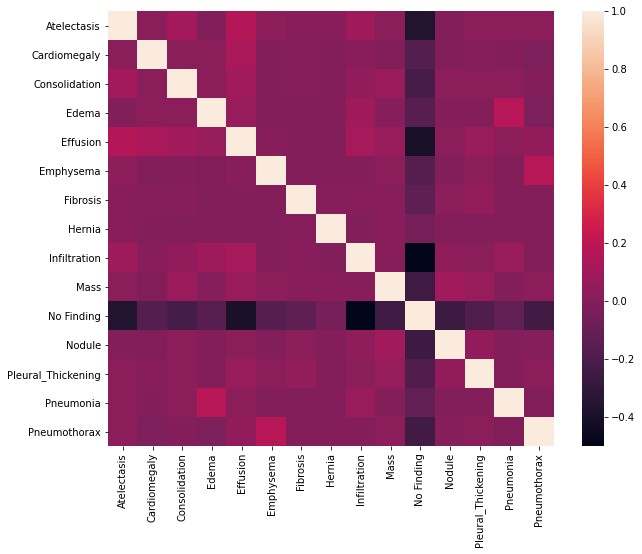

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Atelectasis,1.000000,0.015819,0.108943,-0.003397,0.172445,0.032599,0.011130,0.010830,0.093131,0.018953,-0.366126,-0.007967,0.025202,0.029911,0.031422
Cardiomegaly,0.015819,1.000000,0.015360,0.028318,0.130094,-0.007090,0.004837,0.001762,0.014189,-0.010682,-0.172067,-0.012123,0.009121,0.002848,-0.022248
Consolidation,0.108943,0.015360,1.000000,0.020822,0.101130,-0.000521,0.003236,-0.005413,0.045926,0.074573,-0.225058,0.031819,0.028733,0.025235,0.000485
Edema,-0.003397,0.028318,0.020822,1.000000,0.062092,-0.009204,-0.013243,-0.002326,0.094208,0.002910,-0.156386,0.000261,-0.002032,0.173996,-0.022487
Effusion,0.172445,0.130094,0.101130,0.062092,1.000000,0.011198,-0.002776,-0.003656,0.118136,0.070710,-0.396464,0.019114,0.072009,0.024322,0.047571
Emphysema,0.032599,-0.007090,-0.000521,-0.009204,0.011198,1.000000,-0.000908,-0.001466,0.000406,0.023213,-0.163617,-0.007062,0.026408,-0.004888,0.178175
Fibrosis,0.011130,0.004837,0.003236,-0.013243,-0.002776,-0.000908,1.000000,0.007478,0.008794,0.009959,-0.133433,0.022478,0.053578,-0.006867,0.000094
Hernia,0.010830,0.001762,-0.005413,-0.002326,-0.003656,-0.001466,0.007478,1.000000,-0.003780,0.011927,-0.048640,-0.002422,0.001330,0.000182,-0.001621
Infiltration,0.093131,0.014189,0.045926,0.094208,0.118136,0.000406,0.008794,-0.003780,1.000000,0.014047,-0.501556,0.042749,0.020381,0.073020,0.000576
Mass,0.018953,-0.010682,0.074573,0.002910,0.070710,0.023213,0.009959,0.011927,0.014047,1.000000,-0.251814,0.101253,0.065388,-0.001005,0.029940


In [14]:
corr_matrix = all_xray_df.iloc[:,-len(labels):].corr() # correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix)
plt.show()
corr_matrix

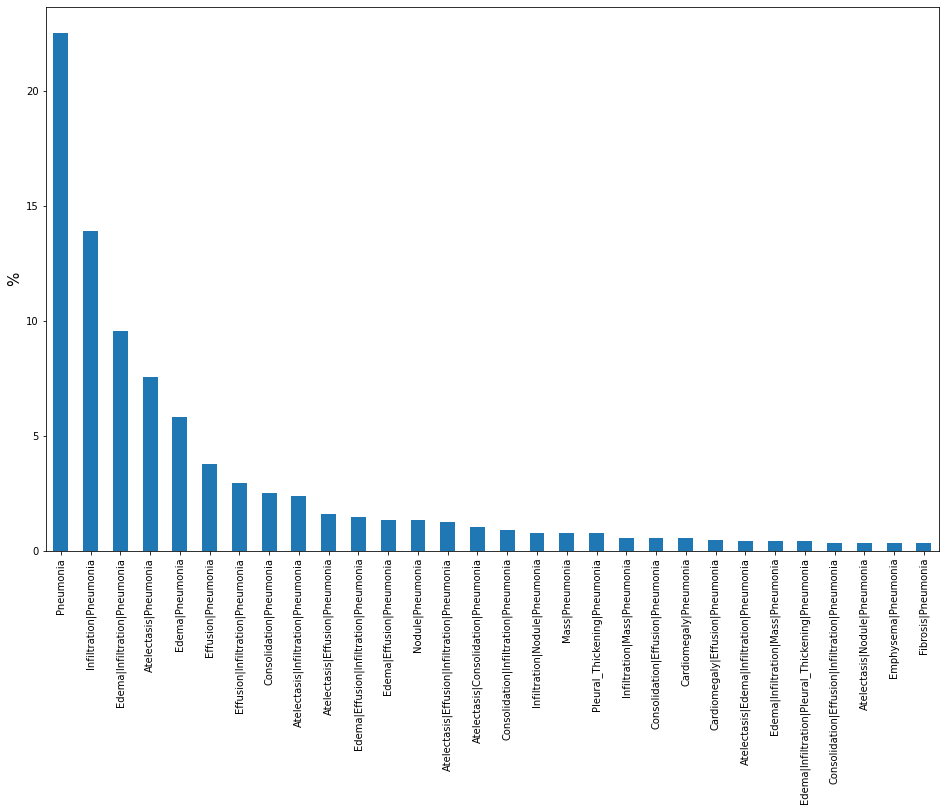

In [15]:
plt.figure(figsize=(16, 10))
comorbidities_numbers = all_xray_df[filt2]['Finding Labels'].value_counts()
_ = (comorbidities_numbers / len(all_xray_df[filt2]) * 100)[:30].plot(kind='bar')
_ = plt.ylabel('%', size=15)

According to the correlation matrix, pneumonia's most common comorbidities are edema and infiltration. This confirmed by the histogram above, which also shows that in more than 75% of cases pneumonia is concurrent with another disease. The most common diseases with pneumonia are infiltration, edema, atelectasis and effusion. Only in around 22.5% of positive cases, pneumonia is found alone.

### Number of diseases per patient

Total patients:  112120
Healthy patients: 53.84%

Patients with disease(s): 46.16%
Among them:
Number Percentage
 1    59.821480
2    27.639638
3     9.381943
4     2.409243
5     0.581541
6     0.129446
7     0.030912
8     0.001932
9     0.003864
dtype: float64


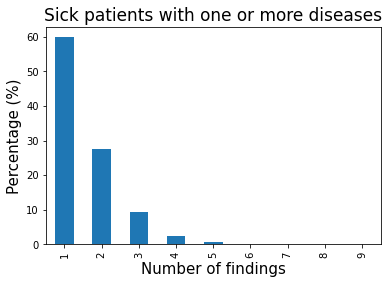

In [16]:
filt3 = (all_xray_df["No Finding"] == 0)
total_patients = len(all_xray_df)
findings = len(all_xray_df[filt3])
no_findings = all_xray_df["No Finding"].sum()

percNumDiseases = all_xray_df[filt3].iloc[:, -len(labels):].sum(axis=1).value_counts(normalize=True, sort=False) * 100

_ = percNumDiseases.plot(kind='bar')
_ = plt.xlabel("Number of findings", size=15)
_ = plt.ylabel("Percentage (%)", size = 15)
_ = plt.title("Sick patients with one or more diseases", size=17)

print("Total patients: ", total_patients)
print("Healthy patients: %.2f%%"%(no_findings / total_patients * 100))
print("\nPatients with disease(s): %0.2f%%"%(findings / total_patients * 100))
print("Among them:\nNumber Percentage\n", percNumDiseases)

46.16% of the patients have one or more diseases. Among them, almost 60% have only one disease, around 28% have two diseases and around 9% three diseases. Combined, patients with 4 or more diseases represent around 3% of the patients with a condition.

### Pixel level assesment of images

In [17]:
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1183,00006271_037.png,No Finding,37,6271,040Y,M,AP,2500,2048,0.171000,0.171000
640,00003303_000.png,No Finding,0,3303,039Y,F,PA,2048,2500,0.171000,0.171000
4391,00021670_027.png,Atelectasis|Cardiomegaly|Effusion,27,21670,045Y,M,PA,2021,2021,0.194311,0.194311


In [18]:
# Split Finding Labels column and turn each label into a column with a binary Flag
labels = np.unique(list(chain(*sample_df["Finding Labels"].map(lambda x: x.split("|")))))
print("Labels: ", labels)
for label in labels:
    sample_df[label] = sample_df["Finding Labels"].map(lambda x: 1 if label in x else 0)
    
sample_df.sample(3)

Labels:  ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3558,00017608_004.png,Infiltration,4,17608,067Y,M,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,0,0
334,00001792_001.png,No Finding,1,1792,044Y,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
776,00004075_000.png,Atelectasis|Pneumonia,0,4075,032Y,F,PA,2048,2500,0.171,...,0,0,0,0,0,0,0,0,1,0
